In [1]:
import numpy as np

In [2]:
# 말뭉치 전처리

def preprocess(text) :
    text = text.lower()
    text = text.replace('.', ' .')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words :
        new_id = len(word_to_id)
        word_to_id[word] = new_id
        id_to_word[new_id] = word

    corpus = np.array([word_to_id[w] for w in words])

    return corpus, word_to_id, id_to_word

In [3]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(word_to_id)
print(word_to_id)

[0 5 2 3 4 5 5 6]
{'you': 0, 'say': 5, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}
{'you': 0, 'say': 5, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


## 동시발생 행렬

### 통계기반 기법 : 어떤 단어에 주목했을 때, 그 주변에 어떤 단어가 몇번이나 등장하는지를 세어 집계

In [5]:
import sys
sys.path.append('..')
import numpy as np
from common.util import preprocess

In [6]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


In [9]:
# 모든 단어에 대해 동시발생하는 단어을 표로 정리 = 동시발생 행렬
# 위 text를 window size = 1로 했을 때 다음의 동시발생 행렬이 만들어짐

C = np.array([
    [0,1,0,0,0,0,0],
    [1,0,1,0,1,1,0],
    [0,1,0,1,0,0,0],
    [0,0,1,0,1,0,0],
    [0,1,0,1,0,0,0],
    [0,1,0,0,0,0,1],
    [0,0,0,0,0,1,0],
])


## id = 0인 단어의 벡터 표현 : you의 경우 동시발생은 say 뿐
print(C[0])

## id = 4인 단어의 벡터 표현 : you의 경우 동시발생은 say, and
print(C[4])

[0 1 0 0 0 0 0]
[0 1 0 1 0 0 0]


In [10]:
# 동시발생 행렬 만드는 함수

def create_co_matrix(corpus, vocab_size, window_size = 1) :
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size))

    for idx, word_id in enumerate(corpus) :
        for i in range(1, window_size+1) :
            left_idx = idx - 1
            right_idx = idx + 1

            if left_idx >= 0 :
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1

            if right_idx < corpus_size :
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
    return co_matrix


In [14]:
result = create_co_matrix(corpus, 7, window_size=1)
print(result)

result == C



[[0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]]


array([[ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True,  True,  True]])

## 벡터 간 유사도

In [15]:
# 코사인 유사도

def cos_similarity(x, y, eps = 1e-8) :
    nx = x / (np.sqrt(np.sum(x**2)) + eps)
    ny = y / (np.sqrt(np.sum(y**2)) + eps)

    return np.dot(nx, ny)

In [16]:
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']]
c1 = C[word_to_id['i']]
print(cos_similarity(c0, c1))


0.7071067691154799


In [17]:
# 코사인 유사도 기반 유사도 랭킹

def most_similar(query, word_to_id, id_to_word, word_matrix, top = 5) :
    if query not in word_to_id :
        print('%s 를 찾을 수 없습니다.' %query)
        return

    print('\n[query]' + query)
    query_id = word_to_id[query]
    query_vec = word_matrix[query_id]

    ## 유사도 계산
    vocab_size = len(id_to_word)
    similarity = np.zeros(vocab_size)
    for i in range(vocab_size) :
        similarity[i] = cos_similarity(word_matrix[i], query_vec)

    ## 내림차순 출력
    count = 0
    for i in (-1*similarity).argsort() :
        if id_to_word[i] == query :
            continue
        print('%s : %s' %(id_to_word[i], similarity[i]))

        count += 1
        if count >= top :
            return

In [1]:
import sys
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

most_similar('you', word_to_id, id_to_word, C, top=5)


[query]you
goodbye : 0.7071067691154799
i : 0.7071067691154799
hello : 0.7071067691154799
say : 0.0
and : 0.0


## 점별 상호정보량 PMI(Point Wise Mutual Information)

In [5]:
# PPMI : PPMI(x, y) = max(0, PMI(x,y))

## C = 동시발생 행렬
## verbose = 진행상황 출력 여부
def ppmi(C, verbose = False, eps = 1e-8) :
    M = np.zeros_like(C)
    N = np.sum(C)
    S = np.sum(C, axis = 0)
    total = C.shape[0] * C.shape[1]
    cnt = 0

    for i in range(C.shape[0]) :
        for j in range(C.shape[1]) :
            pmi = np.log2(C[i,j]*N / (S[j]*S[i] + eps))
            M[i, j] = max(0, pmi)

            if verbose :
                cnt += 1
                if cnt % (total//100) == 0 :
                    print('%.1f%% 완료' %(100*cnt/total))

    return M

In [6]:
import sys
import numpy as np
sys.path.append('..')
from common.util import preprocess, create_co_matrix, most_similar


text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3)
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


/var/folders/qn/f9zmzlh16jsdmwf8nw171lgm0000gn/T/ipykernel_3227/3693810732.py:14: RuntimeWarning: divide by zero encountered in log2
  pmi = np.log2(C[i,j]*N / (S[j]*S[i] + eps))


## SVD

In [7]:
U, S, V = np.linalg.svd(W)

# 동시발생
print(C[0])

# PPMI 행렬
print(W[0])

# SVD
print(U[0])

[0. 1. 0. 0. 0. 0. 0.]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 5.551e-16  3.409e-01 -2.831e-15 -1.205e-01 -9.323e-01  2.220e-16
 -1.996e-16]


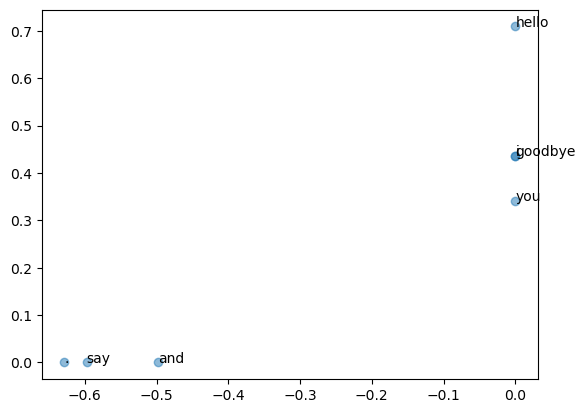

In [8]:
import matplotlib.pyplot as plt

for word, word_id in word_to_id.items() :
    plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha = 0.5)
plt.show()

## PTB 말뭉치로 테스트

In [9]:
sys.path.append('..')
from dataset import ptb

corpus, word_to_id, id_to_word = ptb.load_data('train')

print(len(corpus))

Done
929589


In [2]:
import sys
sys.path.append('..')
from common.util import most_similar, create_co_matrix, ppmi
from sklearn.utils.extmath import randomized_svd
from dataset import ptb

window_size = 2
wordvec_size = 100

corpus, word_to_id, id_to_word = ptb.load_data('train')

vocab_size = len(word_to_id)
print('동시발생 수 계산')
C = create_co_matrix(corpus, vocab_size, window_size)

print('PPMI 계산')
W = ppmi(C, verbose = True)

print('SVD 계산')
# np.linalg는 느림
U, S, V = randomized_svd(W, n_components= wordvec_size, n_iter = 5, random_state=None)

word_vecs = U[:, :wordvec_size]

querys = ['you', 'year', 'car', 'toyota']
for query in querys :
    most_similar(query, word_to_id, id_to_word, word_vecs, top = 5)

동시발생 수 계산
PPMI 계산


/Users/kimtaeyoung/Documents/GitHub/NLP_Scratch2/Ch02/../common/util.py:97: RuntimeWarning: divide by zero encountered in log2
  pmi = np.log2(C[i,j]*N / (S[j]*S[i] + eps))


1.0% 완료
2.0% 완료
3.0% 완료
4.0% 완료
5.0% 완료
6.0% 완료
7.0% 완료
8.0% 완료
9.0% 완료
10.0% 완료
11.0% 완료
12.0% 완료
13.0% 완료
14.0% 완료
15.0% 완료
16.0% 완료
17.0% 완료
18.0% 완료
19.0% 완료
20.0% 완료
21.0% 완료
22.0% 완료
23.0% 완료
24.0% 완료
25.0% 완료
26.0% 완료
27.0% 완료
28.0% 완료
29.0% 완료
30.0% 완료
31.0% 완료
32.0% 완료
33.0% 완료
34.0% 완료
35.0% 완료
36.0% 완료
37.0% 완료
38.0% 완료
39.0% 완료
40.0% 완료
41.0% 완료
42.0% 완료
43.0% 완료
44.0% 완료
45.0% 완료
46.0% 완료
47.0% 완료
48.0% 완료
49.0% 완료
50.0% 완료
51.0% 완료
52.0% 완료
53.0% 완료
54.0% 완료
55.0% 완료
56.0% 완료
57.0% 완료
58.0% 완료
59.0% 완료
60.0% 완료
61.0% 완료
62.0% 완료
63.0% 완료
64.0% 완료
65.0% 완료
66.0% 완료
67.0% 완료
68.0% 완료
69.0% 완료
70.0% 완료
71.0% 완료
72.0% 완료
73.0% 완료
74.0% 완료
75.0% 완료
76.0% 완료
77.0% 완료
78.0% 완료
79.0% 완료
80.0% 완료
81.0% 완료
82.0% 완료
83.0% 완료
84.0% 완료
85.0% 완료
86.0% 완료
87.0% 완료
88.0% 완료
89.0% 완료
90.0% 완료
91.0% 완료
92.0% 완료
93.0% 완료
94.0% 완료
95.0% 완료
96.0% 완료
97.0% 완료
98.0% 완료
99.0% 완료
100.0% 완료
SVD 계산

[query]you
we : 0.8569381668564301
i : 0.8286781965261749
they : 0.6658993451792823
anybody : 0.6026